In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Check that gradients can flow across channel:

In [4]:
channel = CommChannel(size=10, temperature=10, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[0.18207625 0.22752467 0.32462645 0.26577258]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.4901161e-09, 2.9802323e-09, 2.9802323e-09, 2.9802323e-09]],
      dtype=float32)>

In [5]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [6]:
NUM_CLASSES = 3
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [7]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [8]:
inputs, targets = generate_train_batch()

In [9]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

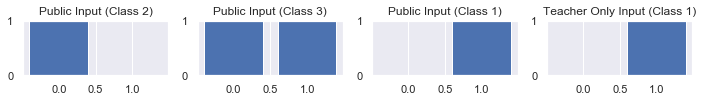

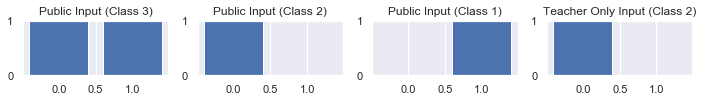

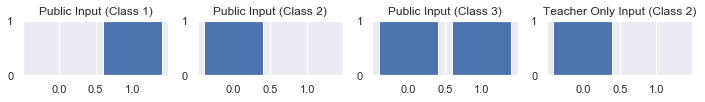

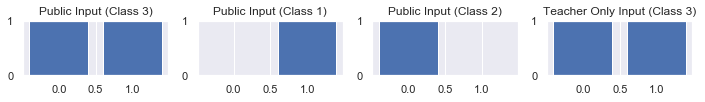

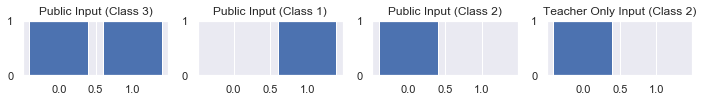

In [10]:
class_labels = list(TRAIN_DATA.keys())

if USE_MNIST:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for i, (ax, inp, tar) in enumerate(zip(axs, inputs, targets)):
        l = tar[row].numpy().argmax() + 1
        if i < NUM_CLASSES:
            ax.set_title(f'Public Input (Class {l})')
        else:
            ax.set_title(f'Teacher Only Input (Class {l})')
        if USE_MNIST:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [11]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[1, 3, 4, 0],
       [2, 4, 0, 3],
       [1, 4, 0, 3],
       [2, 1, 3, 4],
       [1, 2, 0, 4]], dtype=int64)>

## Create Data-Specific Input Encoder

In [12]:
if USE_MNIST:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    AGENT_INPUT_ENCODER = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    AGENT_INPUT_ENCODER = None

CHANNEL_SIZE = 5

### Checking Gradients of Agent Parameters with Respect to Loss Function:

In [13]:
teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
# teacher = experiment.teacher
# student = experiment.student

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student,
                        training=True,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0.5)

    loss = complete_loss_fn(outputs, targets)
#     loss = protocol_diversity_loss(outputs)
#     loss = protocol_entropy(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, student.trainable_variables)

print('Mean Loss:', loss.numpy().mean())

print()

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5 if g is not None else g}')

print()

for v, g in zip(student.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5 if g is not None else g}')

Instructions for updating:
Use tf.identity instead.
Mean Loss: 4.02445

agent/dense/kernel:0 teacher grad norm: 1.9145569801330566
agent/dense/bias:0 teacher grad norm: 1.2756373882293701
agent/lstm/kernel:0 teacher grad norm: 2.9439337253570557
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.5372137427330017
agent/lstm/bias:0 teacher grad norm: 1.886739730834961
agent/dense_1/kernel:0 teacher grad norm: 1.2656759023666382
agent/dense_1/bias:0 teacher grad norm: 2.4926722049713135

agent/dense_2/kernel:0 student grad norm: 2.938469886779785
agent/dense_2/bias:0 student grad norm: 3.668879508972168
agent/lstm_1/kernel:0 student grad norm: 6.252265930175781
agent/lstm_1/recurrent_kernel:0 student grad norm: 2.027495861053467
agent/lstm_1/bias:0 student grad norm: 7.568797588348389
agent/dense_3/kernel:0 student grad norm: 3.1016783714294434
agent/dense_3/bias:0 student grad norm: 8.861833572387695


In [14]:
complete_loss_fn(outputs, targets)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.9790452, 3.691069 , 3.747111 , 4.766826 , 4.1376877, 4.3445144,
       4.4419765, 3.8246706, 3.982658 , 4.4125233, 3.8649118, 3.768912 ,
       4.2827845, 3.9847689, 4.082061 , 4.0792665, 3.9540906, 3.9701257,
       4.730076 , 3.853599 , 4.001568 , 3.87854  , 4.199087 , 4.0383396,
       3.893328 , 4.1202607, 4.0307865, 3.7572594, 3.799089 , 3.618846 ,
       3.690386 , 3.856227 ], dtype=float32)>

In [15]:
teacher.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [16]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, teacher, student,
                    p_mutate=1, 
                    channel_size=CHANNEL_SIZE,
                    kind_mutations=False,
                    training=False)

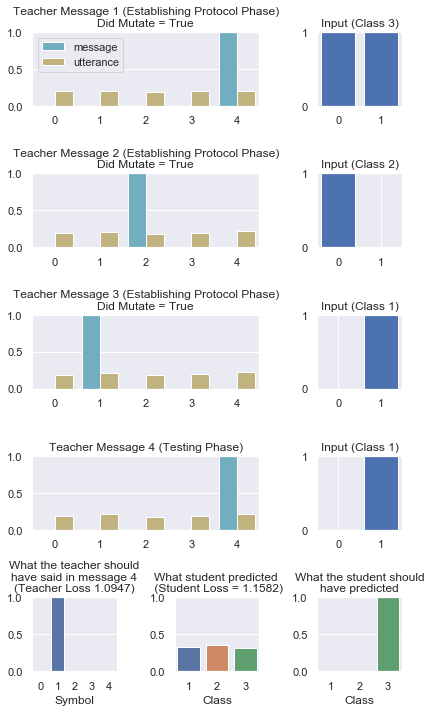

In [17]:
plot_game(inputs, outputs, targets, select_batch=6)

In [18]:
inputs, targets = generate_train_batch()

import unittest.mock as mock
synth_student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, synth_student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5 if g is not None else g}')

agent/dense/kernel:0 teacher grad norm: 1.3299520015716553
agent/dense/bias:0 teacher grad norm: 1.2702685594558716
agent/lstm/kernel:0 teacher grad norm: 2.3631997108459473
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.2695729732513428
agent/lstm/bias:0 teacher grad norm: 2.1810872554779053
agent/dense_1/kernel:0 teacher grad norm: 1.0138263702392578
agent/dense_1/bias:0 teacher grad norm: 3.778663158416748


# Run Experiments

In [19]:
def create_only_student_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=teacher_test_message_is_correct,
        name='only_student_experiment'
    )


def create_only_teacher_test_msg_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        loss_fn=student_pred_matches_implied_class,
        name='only_teacher_test_msg_experiment'
    )


def create_only_teacher_create_protocol_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=lambda o, t: protocol_diversity_loss(o),
        name='only_teacher_create_protocol_experiment'
    )

def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn,
        name='other_play_experiment'
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class,
        name='other_play_separate_optimise_experiment'
    )

def create_self_play_experiment(p_mutate=0.3, epochs=40, 
                                loss_fn=complete_loss_fn):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=loss_fn,
        max_epochs=epochs,
        name='self_play_experiment'
    )

def create_vanilla_experiment(epochs=40, **params):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0.0,
        **params
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        name='vanilla_experiment'
    )

def create_mutation_with_temp_annealing_experiment(
    p_mutate=0.3, channel_size=5, epochs=100, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 1.0
    temp_anneal_end_epoch = 50
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
        }
    
    def loss_fn(o, t):
        return combined_loss_fn(o, t, w=0.5)
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=loss_fn,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

def create_mut_temp_direct_loss_experiment(
    p_mutate=0.3, channel_size=5, epochs=250, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 1.0
    temp_anneal_end_epoch = 50
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
#             'stop_gradients_on_final_message': True,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

def create_message_permutation_experiment(epochs=40):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        name='message_permutation_experiment'
    )

def create_message_permutation_is_all_you_need_experiment(epochs=100):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        name='message_permutation_is_all_you_need'
    )

def create_channel_subset_permutation_experiment(subset_size=3, epochs=100):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': 0,
            'message_permutation': True,
            'permutation_subset_size': subset_size,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        name='channel_subset_permutation'
    )

In [20]:
mutation_temp_anneal_exp = create_mutation_with_temp_annealing_experiment()

In [ ]:
mutation_temp_anneal_exp.max_epochs = 150

In [ ]:
mutation_temp_anneal_exp.run()

In [ ]:
msg_mut_exp = create_self_play_experiment()

In [ ]:
msg_mut_exp.run()

In [ ]:
exp = mutation_temp_anneal_exp
games_played, test_metrics = exp.run_tests()
test_metrics, exp.get_config()

In [ ]:
subset_permutation_exp = create_channel_subset_permutation_experiment(epochs=200)

In [ ]:
subset_permutation_exp.run()

In [ ]:
permutation_experiment = create_message_permutation_is_all_you_need_experiment(epochs=200)

In [ ]:
permutation_experiment.run()

In [20]:
experiment = create_self_play_experiment(p_mutate=0.4)
experiment.run()
experiment.results

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 40, 'steps_per_epoch': 50, 'epochs_optimised': 40, 'play_params': {'channel_size': 5, 'p_mutate': 0.4}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:7, Mean Loss: 3.843
Test Loss: 4.045, Ground Truth F1-Score: 0.323, Student Error: 1.1, Teacher Error: 0.758, Protocol Diversity: 0.521, Protocol Entropy: 0.632,
Epoch 1, Time Taken (mm:ss): 0:8, Mean Loss: 3.78
Epoch 2, Time Taken (mm:ss): 0:11, Mean Loss: 3.743
Epoch 3, Time Taken (mm:ss): 0:12, Mean Loss: 3.761
Epoch 4, Time Taken (mm:ss): 0:14, Mean Loss: 3.744
Epoch 5, Time Taken (mm:ss): 0:16, Mean Loss: 3.704
Test Loss: 3.671, Ground Truth F1-Score: 0.333, Student Error: 1.101, Teache

{'training_params_results': {'mean_test_loss': 1.1654021739959717,
  'mean_ground_truth_f1': 0.96875,
  'ground_truth_acc': 0.96875,
  'mean_student_error': 0.045737601816654205,
  'mean_teacher_error': 0.0321643203496933,
  'mean_protocol_diversity': 0.956250011920929,
  'mean_protocol_entropy': 0.014000236056745052},
 'vanilla_params_results': {'mean_test_loss': 1.2157723903656006,
  'mean_ground_truth_f1': 0.95875,
  'ground_truth_acc': 0.95875,
  'mean_student_error': 0.05848893150687218,
  'mean_teacher_error': 0.058532971888780594,
  'mean_protocol_diversity': 0.9506250023841858,
  'mean_protocol_entropy': 0.015800265595316887},
 'student_responsiveness': 0.977431152091247,
 'teacher_responsiveness': 0.8057915972958922}

In [20]:
experiment = create_self_play_experiment(p_mutate=0.4, loss_fn=student_pred_matches_test_class)
experiment.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 40, 'steps_per_epoch': 50, 'epochs_optimised': 9, 'play_params': {'channel_size': 5, 'p_mutate': 0.4}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'student_pred_matches_test_class'}
Epoch 0, Time Taken (mm:ss): 0:7, Mean Loss: 0.376
Test Loss: 0.476, Ground Truth F1-Score: 0.66, Student Error: 1.328, Teacher Error: 2.715, Protocol Diversity: 0.794, Protocol Entropy: 0.066,
Epoch 1, Time Taken (mm:ss): 0:7, Mean Loss: 0.505
Epoch 2, Time Taken (mm:ss): 0:8, Mean Loss: 0.551
Epoch 3, Time Taken (mm:ss): 0:8, Mean Loss: 0.447
Epoch 4, Time Taken (mm:ss): 0:8, Mean Loss: 0.106
Epoch 5, Time Taken (mm:ss): 0:8, Mean Loss: 0.003
Test Loss: 0.002, Ground Truth F1-Score: 1.0, Student Error: 2.4

In [21]:
experiment.get_results()

{'training_params_results': {'mean_test_loss': 2.1758258299087174e-05,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 3.6031699180603027,
  'mean_teacher_error': 3.742945671081543,
  'mean_protocol_diversity': 0.9368749856948853,
  'mean_protocol_entropy': 0.02020033821463585},
 'vanilla_params_results': {'mean_test_loss': 2.0572615540004335e-05,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 2.0572615540004335e-05,
  'mean_teacher_error': 0.01560766901820898,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222239013367687e-35},
 'student_responsiveness': 8.62135167174442e-05,
 'teacher_responsiveness': 8.283825341721334e-05}

In [24]:
vanilla_params = {
    **experiment.get_play_params(), 
    'p_mutate': 0, 'message_permutation': False,
}
_, vanilla_test_metrics = experiment.run_tests(vanilla_params)
vanilla_test_metrics

{'mean_test_loss': 6.510505199432373,
 'mean_ground_truth_f1': 0.42125,
 'ground_truth_acc': 0.42125,
 'mean_student_error': 3.81645131111145,
 'mean_teacher_error': 0.004055369645357132,
 'mean_protocol_diversity': 0.38499999046325684,
 'mean_protocol_entropy': 1.1538602113723755}

In [25]:
experiment.results

{'training_params_results': {'mean_test_loss': 1.0000003576278687,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 1.7456710565966205e-07,
  'mean_teacher_error': 8.464623988402309e-07,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222239013367687e-35},
 'vanilla_params_results': {'mean_test_loss': 1.0000004768371582,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 1.7650428674187424e-07,
  'mean_teacher_error': 9.766995390236843e-07,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222239013367687e-35},
 'student_responsiveness': 0.9999998509883992,
 'teacher_responsiveness': 0.9999991614351521}

In [ ]:
games_played, test_metrics = subset_permutation_exp.run_tests()

In [ ]:
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1, annot=True);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=1)

In [ ]:
exp = subset_permutation_exp
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(exp.training_history)), 
             y=[item['loss'] for item in exp.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in exp.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * exp.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    if 'error' in metric:
        continue
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=metric,
                 ax=ax)

In [ ]:
import zscomm.loss as losses

In [ ]:
losses.__dict__

In [ ]:
inputs, targets = generate_train_batch()
_, _, num_classes = tf.shape(targets)
num_classes = int(num_classes)
num_classes

In [21]:
experiment = create_self_play_experiment(epochs=15,p_mutate=0.)
experiment.get_config()

{'name': 'self_play_experiment',
 'max_epochs': 15,
 'steps_per_epoch': 50,
 'epochs_optimised': 0,
 'play_params': {'channel_size': 5, 'p_mutate': 0.0},
 'test_freq': 5,
 'test_steps': 25,
 'optimiser_config': {'name': 'RMSprop',
  'learning_rate': 0.01,
  'decay': 0.0,
  'rho': 0.9,
  'momentum': 0.0,
  'epsilon': 1e-07,
  'centered': False},
 'optimise_agents_separately': False,
 'loss_fn': 'complete_loss_fn'}

In [22]:
experiment.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 15, 'steps_per_epoch': 50, 'epochs_optimised': 15, 'play_params': {'channel_size': 5, 'p_mutate': 0.0}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:16, Mean Loss: 3.903
Test Loss: 4.529, Ground Truth F1-Score: 0.341, Student Error: 1.103, Teacher Error: 0.427, Protocol Diversity: 0.333, Protocol Entropy: 1.6,
Epoch 1, Time Taken (mm:ss): 0:14, Mean Loss: 3.823
Epoch 2, Time Taken (mm:ss): 0:13, Mean Loss: 3.855
Epoch 3, Time Taken (mm:ss): 0:13, Mean Loss: 3.758
Epoch 4, Time Taken (mm:ss): 0:13, Mean Loss: 3.73
Epoch 5, Time Taken (mm:ss): 0:13, Mean Loss: 3.735
Test Loss: 3.454, Ground Truth F1-Score: 0.326, Student Error: 1.09, Teach

In [30]:
experiment.results

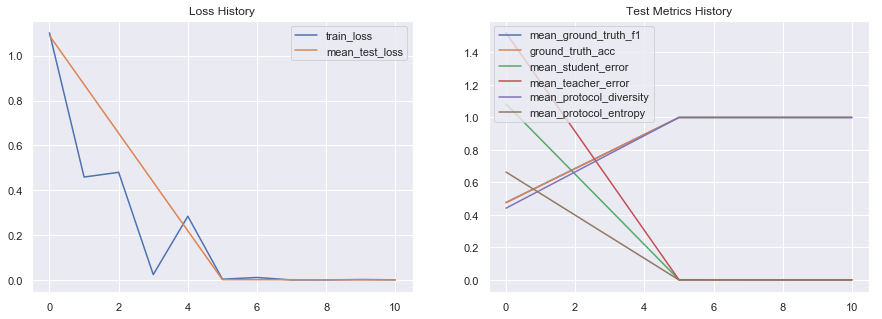

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'] for item in experiment.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in experiment.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * experiment.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=f'{metric}',
                 ax=ax)

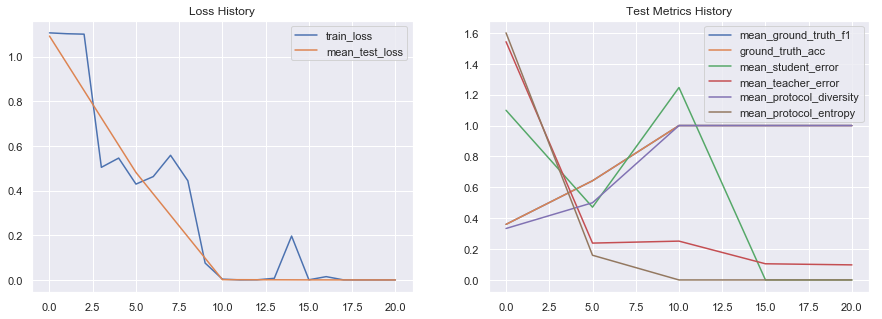

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'] for item in experiment.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in experiment.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * experiment.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=f'{metric}',
                 ax=ax)

In [ ]:
experiment2 = create_self_play_experiment(epochs=100, p_mutate=0.3)

In [ ]:
experiment2.run()

In [ ]:
axs = experiment.plot_training_history()
experiment2.plot_training_history(axs=axs)

## Render Model Graph in Tensorboard

In [ ]:
# # Set up logging.
# from datetime import datetime
# import tensorboard
# %load_ext tensorboard

# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)

# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [ ]:
# %tensorboard --logdir logs

## Analyse Trained Models

In [24]:
games_played, test_metrics = experiment.run_tests({'p_mutate': 0.0})
test_metrics

{'mean_test_loss': 2.234011481050402e-05,
 'mean_ground_truth_f1': 1.0,
 'ground_truth_acc': 1.0,
 'mean_student_error': 2.234011481050402e-05,
 'mean_teacher_error': 0.014839297160506248,
 'mean_protocol_diversity': 1.0,
 'mean_protocol_entropy': 7.222239013367687e-35}

In [62]:
lstm_layer, *_ = [layer for layer in experiment.student.layers
                  if isinstance(layer, tf.keras.layers.LSTM)]
# [(tf.reduce_mean(w), tf.) for w in lstm_layer.weights]
for w in lstm_layer.weights:
    print(w.name, w.numpy().mean(), '+-', w.numpy().std())

agent/lstm_8/kernel:0 0.004633778 +- 0.19918922
agent/lstm_8/recurrent_kernel:0 -0.002707373 +- 0.1492459
agent/lstm_8/bias:0 0.20801497 +- 0.37706983


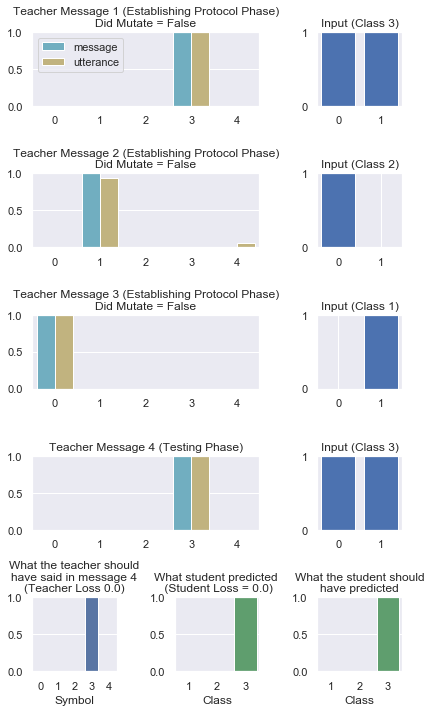

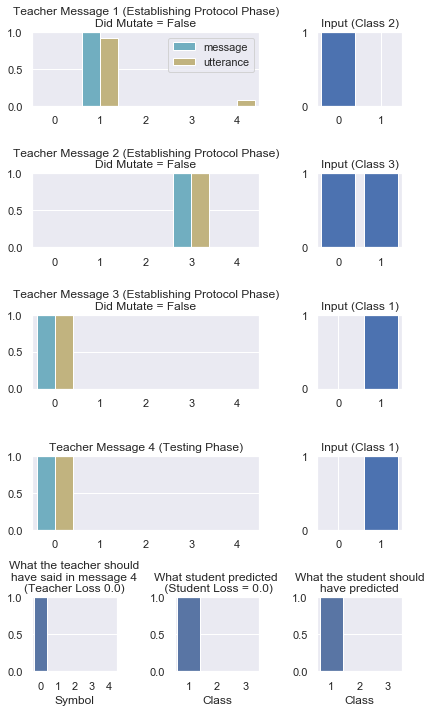

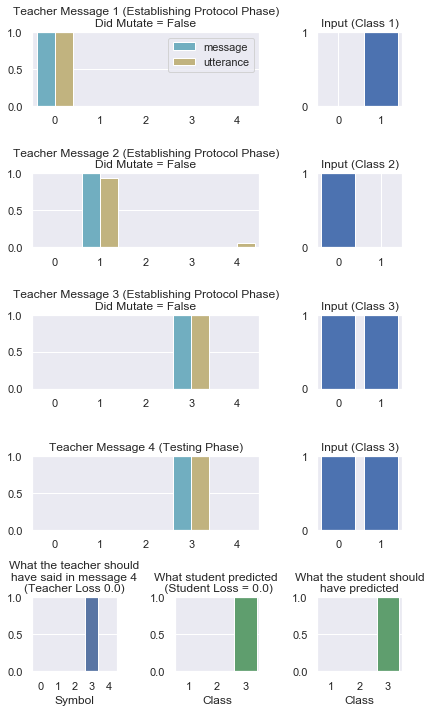

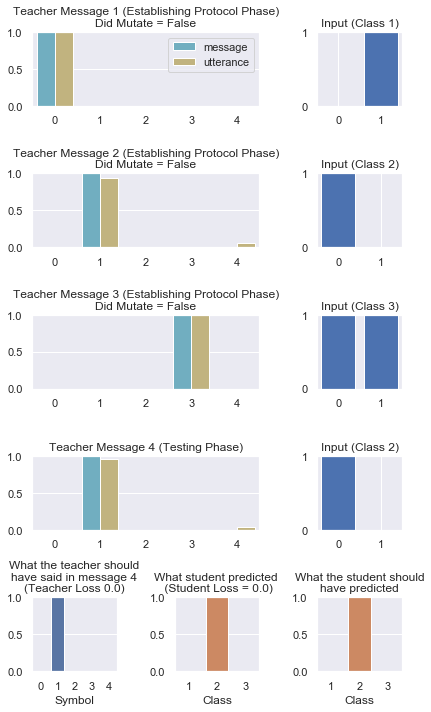

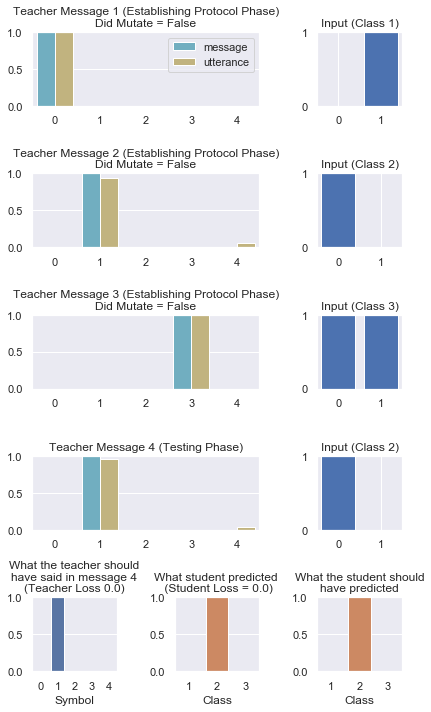

In [25]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

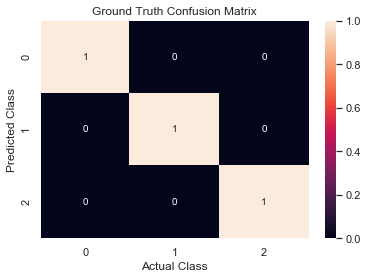

In [44]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

In [ ]:
games_played, _ = experiment2.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

In [23]:
experiment.student.layers[3].activation

<function tensorflow.python.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0)>

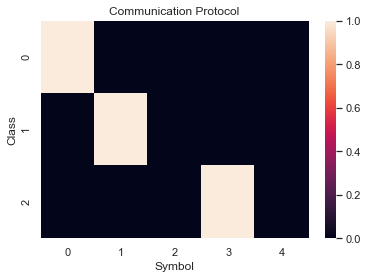

In [26]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [28]:
experiment.get_play_params()

{'channel_size': 5, 'p_mutate': 0.4}

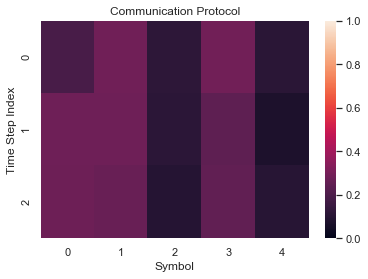

In [27]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_index_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Time Step Index')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
games_played, _ = experiment2.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=1)

## Zero-shot Coordination

In [ ]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment.teacher, 
    experiment2.student, 
    training=False, 
    p_mutate=0,
)

test_metrics = experiment.extract_test_metrics([(inputs, targets, outputs)])
experiment.print_test_metrics(test_metrics)

In [ ]:
plot_game(inputs, outputs, targets, select_batch=0)

In [ ]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment2.teacher, 
    experiment.student, 
    training=False, 
    p_mutate=0,
)

test_metrics = experiment.extract_test_metrics([(inputs, targets, outputs)])
experiment.print_test_metrics(test_metrics)

In [ ]:
plot_game(inputs, outputs, targets, select_batch=4)